In [1]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
#torch.cuda.get_device_properties(0).total_memory

#### Load model

In [2]:
#model_name = "llava-hf/llava-1.5-7b-hf"
#model_name = "bczhou/tiny-llava-v1-hf"
model_name = "unsloth/llava-1.5-7b-hf-bnb-4bit"

#model =  LlavaForConditionalGeneration.from_pretrained(
    #model_name,
    #torch_dtype=torch.bfloat16,
    #attn_implementation="flash_attention_2",
    #device_map="auto",
#)

model = LlavaForConditionalGeneration.from_pretrained(
    model_name, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True,
    use_flash_attention_2=True
).to(0)

#model = LlavaForConditionalGeneration.from_pretrained(
    #model_name,
    #torch_dtype=torch.bfloat16,
    #device_map="cpu",
#)

model.eval()

# load processor
processor = AutoProcessor.from_pretrained(model_name)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


model.safetensors:  29%|##8       | 1.16G/4.04G [00:00<?, ?B/s]

The model was loaded with use_flash_attention_2=True, which is deprecated and may be removed in a future release. Please use `attn_implementation="flash_attention_2"` instead.


generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

#### Image

In [3]:
# TODO: image and caption from sugarcrepe

url = "https://www.ilankelman.org/stopsigns/australia.jpg"
image = Image.open(requests.get(url, stream=True).raw)

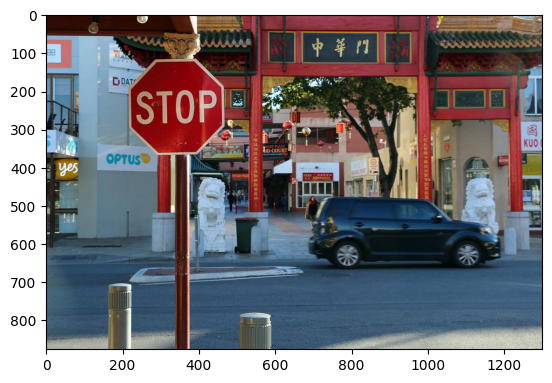

In [4]:
plt.imshow(image)

#### Process image

In [5]:
prompt = "USER: <image>\nDescribe the image. ASSISTANT:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)

In [6]:
inputs

{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 3

In [7]:
output = model.generate(**inputs, max_new_tokens=200, do_sample=False)
print(processor.decode(output[0][2:], skip_special_tokens=True))

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


ER:  
Describe the image. ASSISTANT: The image depicts a busy city street with a stop sign prominently displayed at the intersection. The street is lined with various shops and businesses, creating a lively atmosphere.

There are several people walking along the street, with some closer to the stop sign and others further away. A car is driving down the street, and a truck is parked nearby. Additionally, there are two potted plants placed along the street, adding to the urban aesthetic.

The scene captures the essence of a bustling city street with people going about their daily activities.


#### Forward pass

In [30]:
# 32+1 layers
# each layer hidden_state -> b x seq_len x embed_dim [ignoring b = 1]

# model.vision_tower = CLIPVisionModel
# model.config.vision_feature_layer = -2

# pixel_values : torch.Size([1, 3, 336, 336])
# patch_embeds: torch.Size([1, 1024, 24, 24])
# patch_embeds flattened : torch.Size([1, 576, 1024])
# embeddings : torch.Size([1, 577, 1024])
# hidden_states : torch.Size([1, 577, 1024])
# hidden_states output -2 layer : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 577, 1024])
# selected_image_feature : torch.Size([1, 576, 1024])
# image_features : torch.Size([1, 576, 4096])

In [8]:
output = model(**inputs, output_hidden_states=True)

#### Get softmax scores for layer

In [9]:
image_indices = torch.nonzero((inputs['input_ids'][0] == model.config.image_token_index).long())
image_indices = image_indices.flatten()
reps = torch.vstack(output['hidden_states'])    # 33, 593, 4096

In [11]:
image_reps = torch.index_select(reps, 1, image_indices)
#image_reps = torch.rand(33, 576, 4096).to(torch.bfloat16)

unembed_matrix = model.language_model.lm_head
unembedded_image_reps = unembed_matrix(image_reps)

scores = F.softmax(unembedded_image_reps, dim=1)


In [12]:
scores.shape

torch.Size([33, 576, 32064])

#### Get max tokens

In [60]:
max_tokens = torch.argmax(scores, dim=2)
#processor.tokenizer.decode(max_tokens)

In [61]:
max_tokens.shape

torch.Size([33, 576])

In [ ]:
# tree? signs?

In [ ]:
# How to map patch_embeds to pixel_values?

In [62]:
scores.shape

# scores for all layers

# TODO: map yourself

torch.Size([33, 576, 32064])

In [13]:
def internal_confidence_heatmap(tokenizer, scores, object):
    class_token_indices = tokenizer.encode(object)[1:]
    #return torch.max(scores[:, :, class_token_indices], dim=0).values
    return torch.squeeze(scores[:, :, class_token_indices], dim=2).T

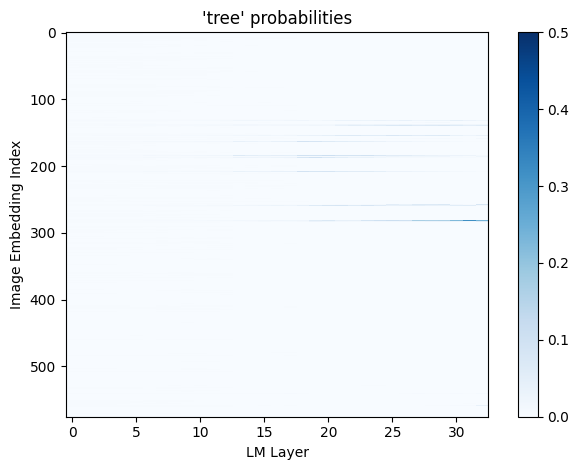

In [34]:
object = 'tree'
#object = 'car'
#object = 'signs'
#object = 'red'
heatmap_data = internal_confidence_heatmap(processor.tokenizer, scores, object).detach().cpu().float()
num_image_embeddings = scores.shape[1]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{object}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 0.5)   # 0, 1
plt.colorbar()
plt.show()

In [35]:
def internal_confidence_segmentation(tokenizer, scores, object, num_patches=24):
    class_token_indices = tokenizer.encode(object)[1:]
    obj_socres = torch.squeeze(scores[:, :, class_token_indices], dim = 2)
    max_obj_scores = torch.max(obj_socres, dim=0).values.reshape(num_patches, num_patches).float()
    return max_obj_scores

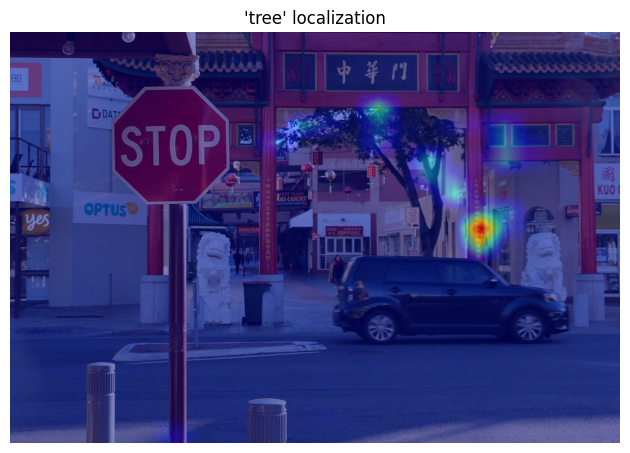

In [36]:
img_width, img_height = image.size

segmentation = internal_confidence_segmentation(processor.tokenizer, scores, object, num_patches=24)
segmentation_resized = (np.array(Image.fromarray(segmentation.detach().cpu().numpy()).resize((img_width, img_height), Image.BILINEAR)))

plt.imshow(image)
plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
plt.axis('off')
plt.title(f"'{object}' localization")
plt.tight_layout()
plt.show()